Plotting synoptic maps from the GFS analysis 
========================================

Use Xarray module to read in model data from nomads server.

This example uses the xarray module to access data from the nomads server for
archived GFS analysis data via OPeNDAP. Xarray makes it easier to select times
and levels, although you still have to know the coordinate variable name. A
simple 500 hPa plot is created after selecting with xarray.

Adapted from: https://unidata.github.io/python-training/gallery/xarray_500hpa_map/

Imports

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
import pandas as pd

import metpy.calc as mpcalc
from metpy.units import units

from palettable.colorbrewer.diverging import BrBG_11

enDash = u'\u2013'

Accessing data using Xarray
---------------------------

In [2]:
# Specify our date/time of product desired
dt = datetime(2025, 1, 29, 12)  ## year, month, day, hour, minute, second

archived = False ### is this an old time (more than ~1 month ago), where we need to get from NOMADS?
archived_old = False  ### or is it a *really* old time (more than ~1 year ago), to get from a different spot

if archived==True:
    #########for archived data, use NCEI below:
    base_url = "https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files/"
    data = xr.open_dataset(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/'
                           f'gfs_4_{dt:%Y%m%d}_{dt:%H}00_000.grb2',
                           decode_times=True)

if archived_old==True:
    #########for archived data, use NCEI below:
    base_url = "https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files-old/"
    data = xr.open_dataset(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/'
                           f'gfsanl_4_{dt:%Y%m%d}_{dt:%H}00_000.grb2',
                           decode_times=True)
    
else:
    ########### for near-real-time data, use unidata thredds
    base_url = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg_ana/"
    data = xr.open_dataset(f'{base_url}GFS_Global_0p5deg_ana_{dt:%Y%m%d}_{dt:%H}00.grib2',
                           decode_times=True)

    
    

In [3]:
data

<xarray.Dataset> Size: 634MB
Dimensions:                                                          (lat: 361,
                                                                      lon: 720,
                                                                      time: 1,
                                                                      altitude_above_msl: 3,
                                                                      sigma_layer: 4,
                                                                      pressure_difference_layer: 1,
                                                                      ...
                                                                      sigma: 1,
                                                                      pressure_difference_layer1: 1,
                                                                      hybrid: 1,
                                                                      sigma_layer_bounds_1: 2,
                                                                      pressure_difference_layer_bounds_1: 2,
                                                                      pressure_difference_layer1_bounds_1: 2)
Coordinates: (12/15)
  * lat                                                              (lat) float32 1kB ...
  * lon                                                              (lon) float32 3kB ...
    reftime                                                          datetime64[ns] 8B ...
  * time                                                             (time) datetime64[ns] 8B ...
  * altitude_above_msl                                               (altitude_above_msl) float32 12B ...
  * sigma_layer                                                      (sigma_layer) float32 16B ...
    ...                                                               ...
  * height_above_ground                                              (height_above_ground) float32 8B ...
  * potential_vorticity_surface                                      (potential_vorticity_surface) float32 8B ...
  * height_above_ground1                                             (height_above_ground1) float32 24B ...
  * sigma                                                            (sigma) float32 4B ...
  * pressure_difference_layer1                                       (pressure_difference_layer1) float32 4B ...
  * hybrid                                                           (hybrid) float32 4B ...
Dimensions without coordinates: sigma_layer_bounds_1,
                                pressure_difference_layer_bounds_1,
                                pressure_difference_layer1_bounds_1
Data variables: (12/83)
    LatLon_Projection                                                int32 4B ...
    sigma_layer_bounds                                               (sigma_layer, sigma_layer_bounds_1) float32 32B ...
    pressure_difference_layer_bounds                                 (pressure_difference_layer, pressure_difference_layer_bounds_1) float32 8B ...
    pressure_difference_layer1_bounds                                (pressure_difference_layer1, pressure_difference_layer1_bounds_1) float32 8B ...
    Absolute_vorticity_isobaric                                      (time, isobaric, lat, lon) float32 43MB ...
    Cloud_mixing_ratio_hybrid                                        (time, hybrid, lat, lon) float32 1MB ...
    ...                                                               ...
    v-component_of_wind_potential_vorticity_surface                  (time, potential_vorticity_surface, lat, lon) float32 2MB ...
    v-component_of_wind_maximum_wind                                 (time, lat, lon) float32 1MB ...
    v-component_of_wind_altitude_above_msl                           (time, altitude_above_msl, lat, lon) float32 3MB ...
    v-component_of_wind_height_above_ground                          (time, height_above_ground1, lat, lon) float32 6MB ...
    v-component

Convert time in file to pandas datetime

In [4]:
#vtime = pd.to_datetime(data.time)[0]
vtime = pd.to_datetime(dt)
vtime


Timestamp('2025-01-29 12:00:00')

Get relevant variables

In [5]:
data_subset = data.metpy.parse_cf([
    'u-component_of_wind_isobaric',
    'v-component_of_wind_isobaric',
    'Temperature_isobaric',
    'Geopotential_height_isobaric',
    'Relative_humidity_isobaric',
    'Geopotential_height_surface',
    #'Relative_humidity_height_above_ground',
    'Pressure_reduced_to_MSL_msl',
    'u-component_of_wind_height_above_ground',
    'v-component_of_wind_height_above_ground' 
]).sel(time=vtime).squeeze()

## subset to North America
data_subset = data_subset.sel(lon=slice(205,310.), lat=slice(68.,18.))    

Inspect data:

In [6]:
data_subset

<xarray.Dataset> Size: 19MB
Dimensions:                                  (lat: 101, lon: 211, isobaric: 41,
                                              height_above_ground1: 6)
Coordinates:
  * lat                                      (lat) float32 404B 68.0 ... 18.0
  * lon                                      (lon) float32 844B 205.0 ... 310.0
    reftime                                  datetime64[ns] 8B 2025-01-29T12:...
    time                                     datetime64[ns] 8B 2025-01-29T12:...
  * isobaric                                 (isobaric) float32 164B 1.0 ... ...
    metpy_crs                                object 8B Projection: latitude_l...
  * height_above_ground1                     (height_above_ground1) float32 24B ...
Data variables:
    u-component_of_wind_isobaric             (isobaric, lat, lon) float32 3MB ...
    v-component_of_wind_isobaric             (isobaric, lat, lon) float32 3MB ...
    Temperature_isobaric                     (isobaric, lat, lon) float32 3MB ...
    Geopotential_height_isobaric             (isobaric, lat, lon) float32 3MB ...
    Relative_humidity_isobaric               (isobaric, lat, lon) float32 3MB ...
    Geopotential_height_surface              (lat, lon) float32 85kB ...
    Pressure_reduced_to_MSL_msl              (lat, lon) float32 85kB ...
    u-component_of_wind_height_above_ground  (height_above_ground1, lat, lon) float32 511kB ...
    v-component_of_wind_height_above_ground  (height_above_ground1, lat, lon) float32 511kB ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

Get 500-hPa fields, smooth, and calculate vorticity
----------------------

In [7]:
hght_500 = mpcalc.smooth_n_point(data_subset['Geopotential_height_isobaric'].metpy.sel(vertical=500*units.hPa), 5)
uwnd_500 = data_subset['u-component_of_wind_isobaric'].metpy.sel(vertical=500*units.hPa)
vwnd_500 = data_subset['v-component_of_wind_isobaric'].metpy.sel(vertical=500*units.hPa)

avor_500 = mpcalc.smooth_n_point(mpcalc.absolute_vorticity(uwnd_500, vwnd_500),9)


And make the map
---------------

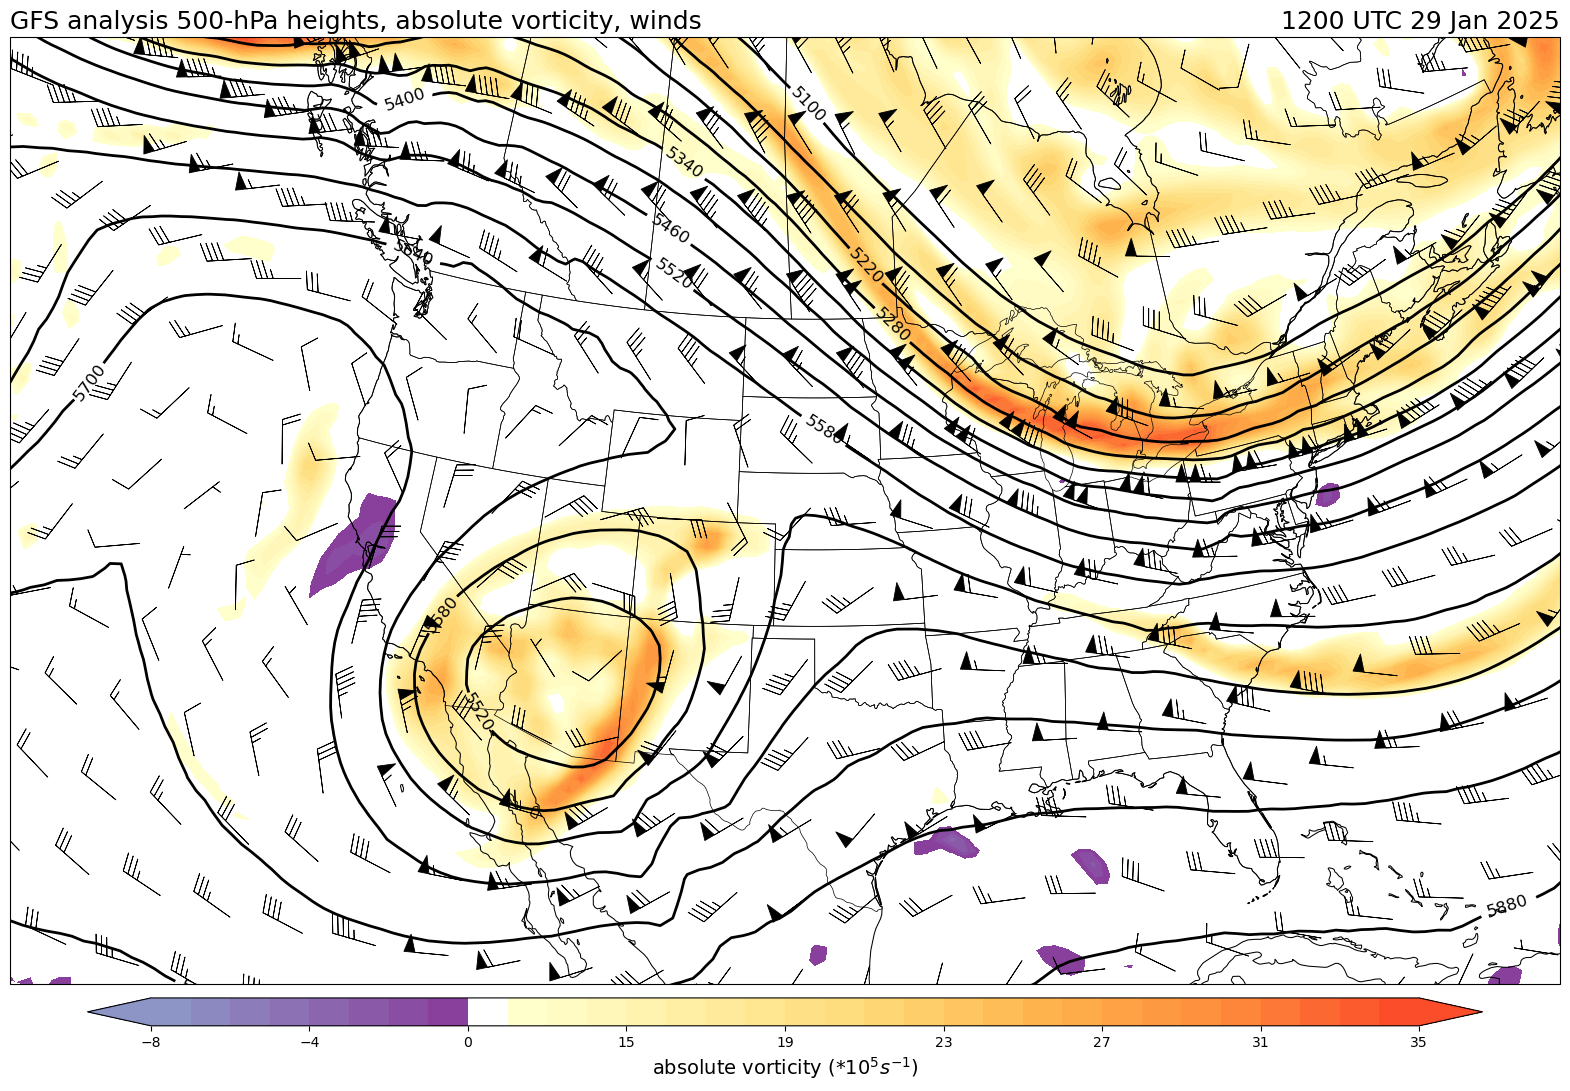

In [8]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# Plot Titles
plt.title(r'GFS analysis 500-hPa heights, absolute vorticity, winds',
          loc='left', fontsize=18)
plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=18)

# Plot Background
#ax.set_extent([217.5, 290., 18., 66.])
ax.set_extent([227.5, 290., 20., 56.])
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Height Contours
clev500 = np.arange(5100, 6061, 60)
cs = ax.contour(data_subset.lon, data_subset.lat, hght_500, clev500, colors='black', linewidths=2,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Absolute Vorticity colors
# Use two different colormaps from matplotlib and combine into one color set
clevs_500_avor = list(range(-8, 1, 1))+list(range(12, 36, 1))
colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 36))
colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
colors = np.vstack((colors2, (1, 1, 1, 1), colors1))

# Plot absolute vorticity values (multiplying by 10^5 to scale appropriately)
cf = ax.contourf(data_subset.lon, data_subset.lat, avor_500*1e5, clevs_500_avor, colors=colors, extend='both',
                 transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9)
cb.set_label('absolute vorticity ($*10^5 s^{-1}$)', fontsize=14)

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
wind_slice = slice(None, None, 6)
ax.barbs(uwnd_500.lon[wind_slice], uwnd_500.lat[wind_slice], uwnd_500.metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         vwnd_500.metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         length=8, linewidth=0.6,pivot='middle', transform=ccrs.PlateCarree())

outfile="500vort_gfs_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png"
fig.savefig(outfile, dpi=255, bbox_inches='tight', transparent=False, facecolor='white')
#os.system("mv "+outfile+" "+case_date+"/.")
plt.show()

plt.close('all')

Repeat but do thickness and geostrophic vorticity and thermal wind
-------------


In [9]:
hght_500 = data_subset['Geopotential_height_isobaric'].metpy.sel(vertical=500*units.hPa)
hght_900 = data_subset['Geopotential_height_isobaric'].metpy.sel(vertical=900*units.hPa)
thk_900_500 = mpcalc.smooth_n_point(hght_500 - hght_900,9) * units('m')

### geostrophic wind
ugeo_500, vgeo_500 = mpcalc.geostrophic_wind(hght_500)

ugeo_500 = mpcalc.smooth_n_point(ugeo_500,9)
vgeo_500 = mpcalc.smooth_n_point(vgeo_500,9)

### geostrophic vorticity
avor_geo_500 = mpcalc.smooth_n_point(mpcalc.absolute_vorticity(ugeo_500, vgeo_500),9)

### and thermal wind
utherm_500, vtherm_500 = mpcalc.geostrophic_wind(thk_900_500)


And make the map
----------

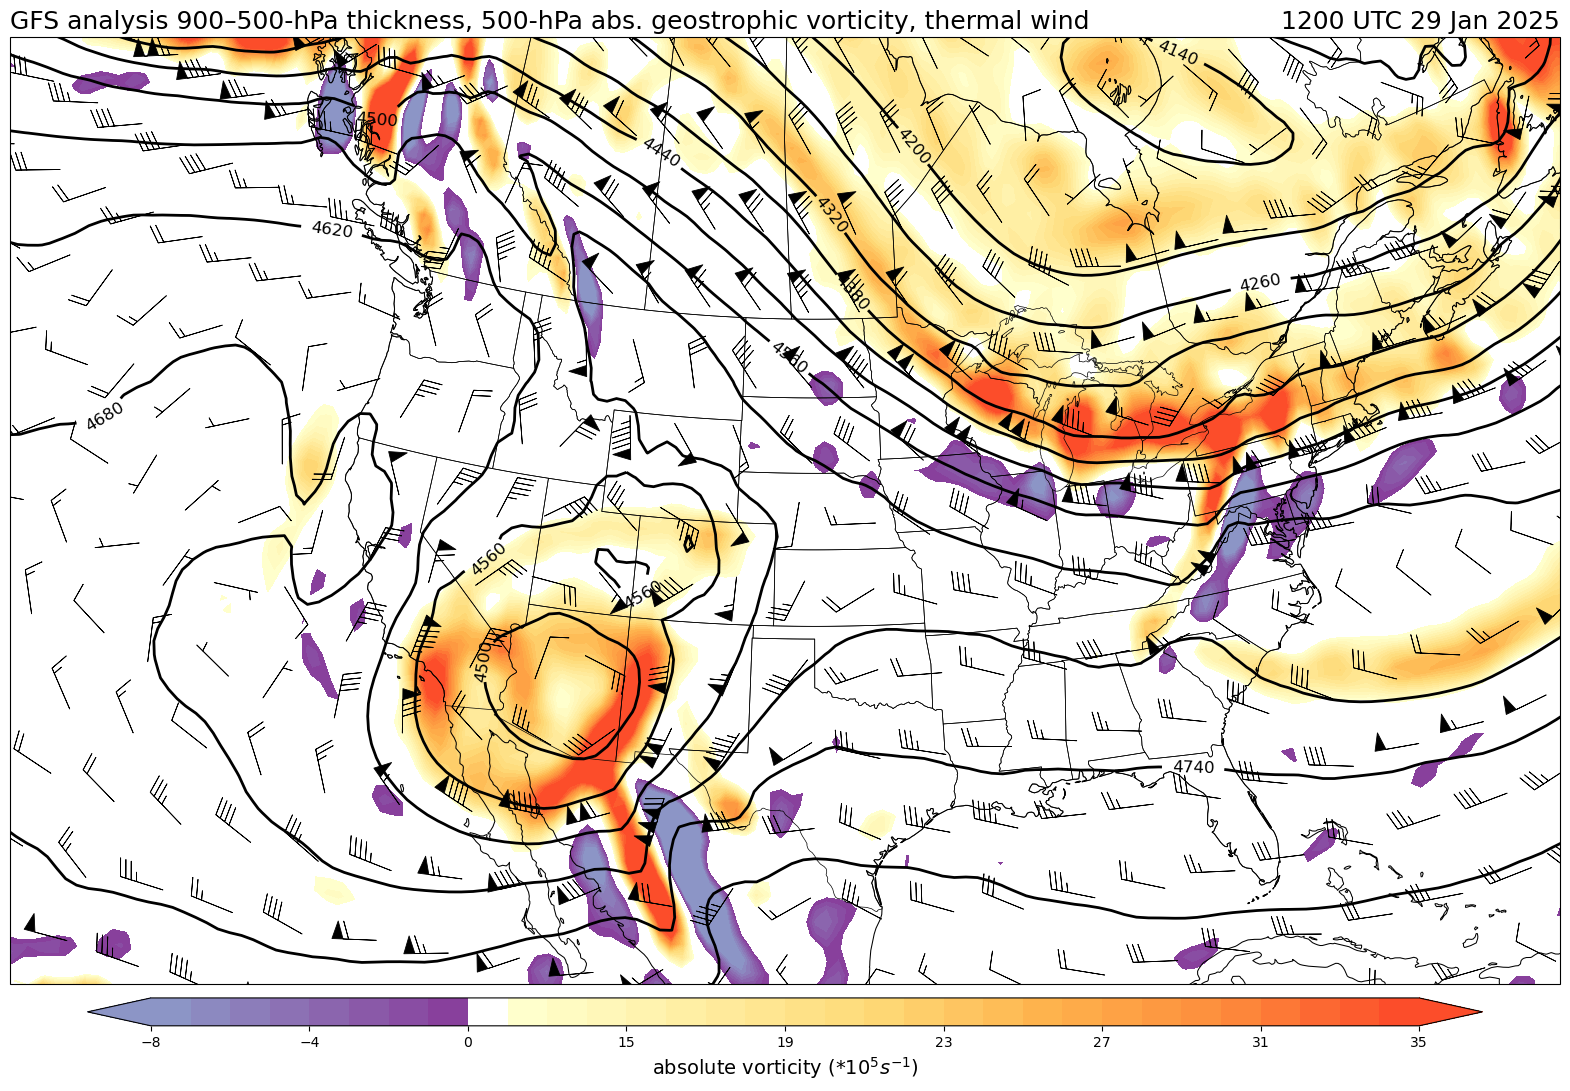

In [10]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)



# Plot Titles
plt.title(r"GFS analysis 900{0}500".format(enDash)+"-hPa thickness, 500-hPa abs. geostrophic vorticity, thermal wind",
          loc='left', fontsize=18)
plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=18)

# Plot Background
#ax.set_extent([217.5, 290., 18., 66.])
ax.set_extent([227.5, 290., 20., 56.])
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Height Contours
clev500 = np.arange(3960, 6061, 60)
cs = ax.contour(data_subset.lon, data_subset.lat, thk_900_500, clev500, colors='black', linewidths=2,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Absolute Vorticity colors
# Use two different colormaps from matplotlib and combine into one color set
clevs_500_avor = list(range(-8, 1, 1))+list(range(12, 36, 1))
colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 36))
colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
colors = np.vstack((colors2, (1, 1, 1, 1), colors1))

# Plot absolute vorticity values (multiplying by 10^5 to scale appropriately)
cf = ax.contourf(data_subset.lon, data_subset.lat, avor_geo_500*1e5, clevs_500_avor, colors=colors, extend='both',
                 transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9)
cb.set_label('absolute vorticity ($*10^5 s^{-1}$)', fontsize=14)

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
wind_slice = slice(None, None, 6)
ax.barbs(utherm_500.lon[wind_slice], utherm_500.lat[wind_slice], utherm_500.metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         vtherm_500.metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         length=8, linewidth=0.6,pivot='middle', transform=ccrs.PlateCarree())

outfile="500geovort_thk_gfs_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png"
fig.savefig(outfile, dpi=255, bbox_inches='tight', transparent=False, facecolor='white')
#os.system("mv "+outfile+" "+case_date+"/.")
plt.show()

plt.close('all')

Now do 850-mb temperature
------------

In [13]:
hght_850 = mpcalc.smooth_n_point(data_subset['Geopotential_height_isobaric'].metpy.sel(vertical=850*units.hPa), 5)
uwnd_850 = mpcalc.smooth_n_point(data_subset['u-component_of_wind_isobaric'].metpy.sel(vertical=850*units.hPa), 5)
vwnd_850 = mpcalc.smooth_n_point(data_subset['v-component_of_wind_isobaric'].metpy.sel(vertical=850*units.hPa), 5)
tmpk_850 = mpcalc.smooth_n_point(data_subset['Temperature_isobaric'].metpy.sel(vertical=850*units.hPa), 9)

tmpc_850 = tmpk_850.metpy.convert_units("degC")

And map
------------

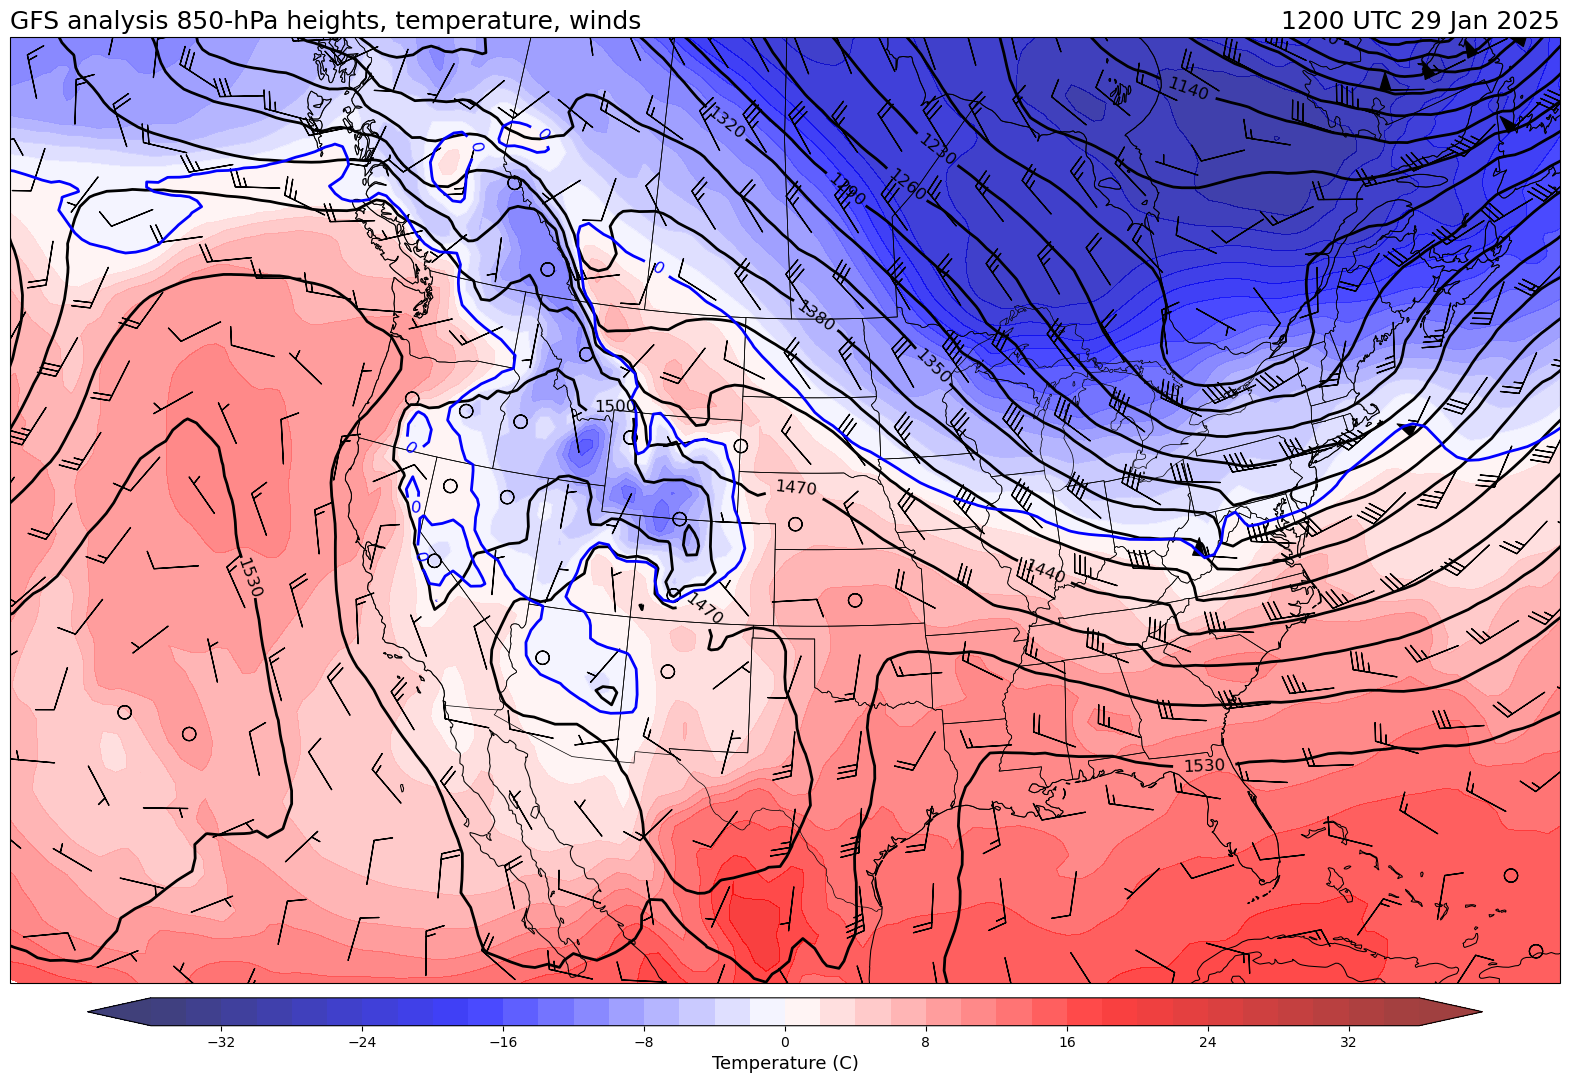

In [14]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# Plot Titles
plt.title(r'GFS analysis 850-hPa heights, temperature, winds',
          loc='left', fontsize=18)
plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=18)

# Plot Background
#ax.set_extent([217.5, 290., 18., 66.])
ax.set_extent([227.5, 290., 20., 56.])
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Height Contours
clev850 = np.arange(0,3001,30)
cs = ax.contour(data_subset.lon, data_subset.lat, hght_850, clev850, colors='black', linewidths=2,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot colorfill and dashed contours of 850-hPa temperatures in Celsius
clevs_850_tmpc = np.arange(-36, 38, 2)
cf = ax.contourf(data_subset.lon, data_subset.lat, tmpc_850, clevs_850_tmpc, alpha=0.75,
                 cmap=plt.cm.seismic, extend='both', transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9)
cb.set_label('Temperature (C)', fontsize=13)

## plot the 0C line
clev_thk = [0]
cs4 = ax.contour(data_subset.lon, data_subset.lat, tmpc_850, clev_thk, colors='blue',
                 linewidths=2, transform=ccrs.PlateCarree())
plt.clabel(cs4, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                 rightside_up=True, use_clabeltext=True)

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
wind_slice = slice(None, None, 6)
ax.barbs(uwnd_850.lon[wind_slice], uwnd_850.lat[wind_slice], uwnd_850.metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         vwnd_850.metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         length=8, linewidth=0.9,
         pivot='middle', transform=ccrs.PlateCarree())

outfile="850temp_gfs_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png"
fig.savefig(outfile, dpi=255, bbox_inches='tight', transparent=False, facecolor='white')
#os.system("mv "+outfile+" "+case_date+"/.")
plt.show()

plt.close('all')

Now also Q-vectors
------------

In [15]:
dx, dy = mpcalc.lat_lon_grid_deltas(data_subset.lon, data_subset.lat)

hght_700 = data_subset['Geopotential_height_isobaric'].metpy.sel(vertical=700*units.hPa)
uwnd_700 = data_subset['u-component_of_wind_isobaric'].metpy.sel(vertical=700*units.hPa)
vwnd_700 = data_subset['v-component_of_wind_isobaric'].metpy.sel(vertical=700*units.hPa)
tmpk_700 = data_subset['Temperature_isobaric'].metpy.sel(vertical=700*units.hPa)

# Use MetPy to calculate the wind speed before smoothing, change units to knots from m/s
sped_700 = mpcalc.wind_speed(uwnd_700, vwnd_700).metpy.convert_units('kt')

## first, smooth everything pretty heavily:
tmpk_700 = ndimage.gaussian_filter(tmpk_700, sigma=4, order=0) * units('kelvin')
uwnd_700 = ndimage.gaussian_filter(uwnd_700, sigma=4, order=0) * units('m/s')
vwnd_700 = ndimage.gaussian_filter(vwnd_700, sigma=4, order=0) * units('m/s')       

# less smoothing for the height
hght_700 = ndimage.gaussian_filter(hght_700, sigma=2, order=0) * units('m')

# Compute the Q-vector components
uqvect, vqvect = mpcalc.q_vector(uwnd_700, vwnd_700, tmpk_700, 700*units.hPa, dx, dy)

# Compute the divergence of the Q-vectors calculated above
q_div = -2*mpcalc.divergence(uqvect, vqvect, dx=dx, dy=dy)

## smooth it too
q_div = ndimage.gaussian_filter(q_div, sigma=4, order=0) * units('meter/(kilogram second)')

And map
----------

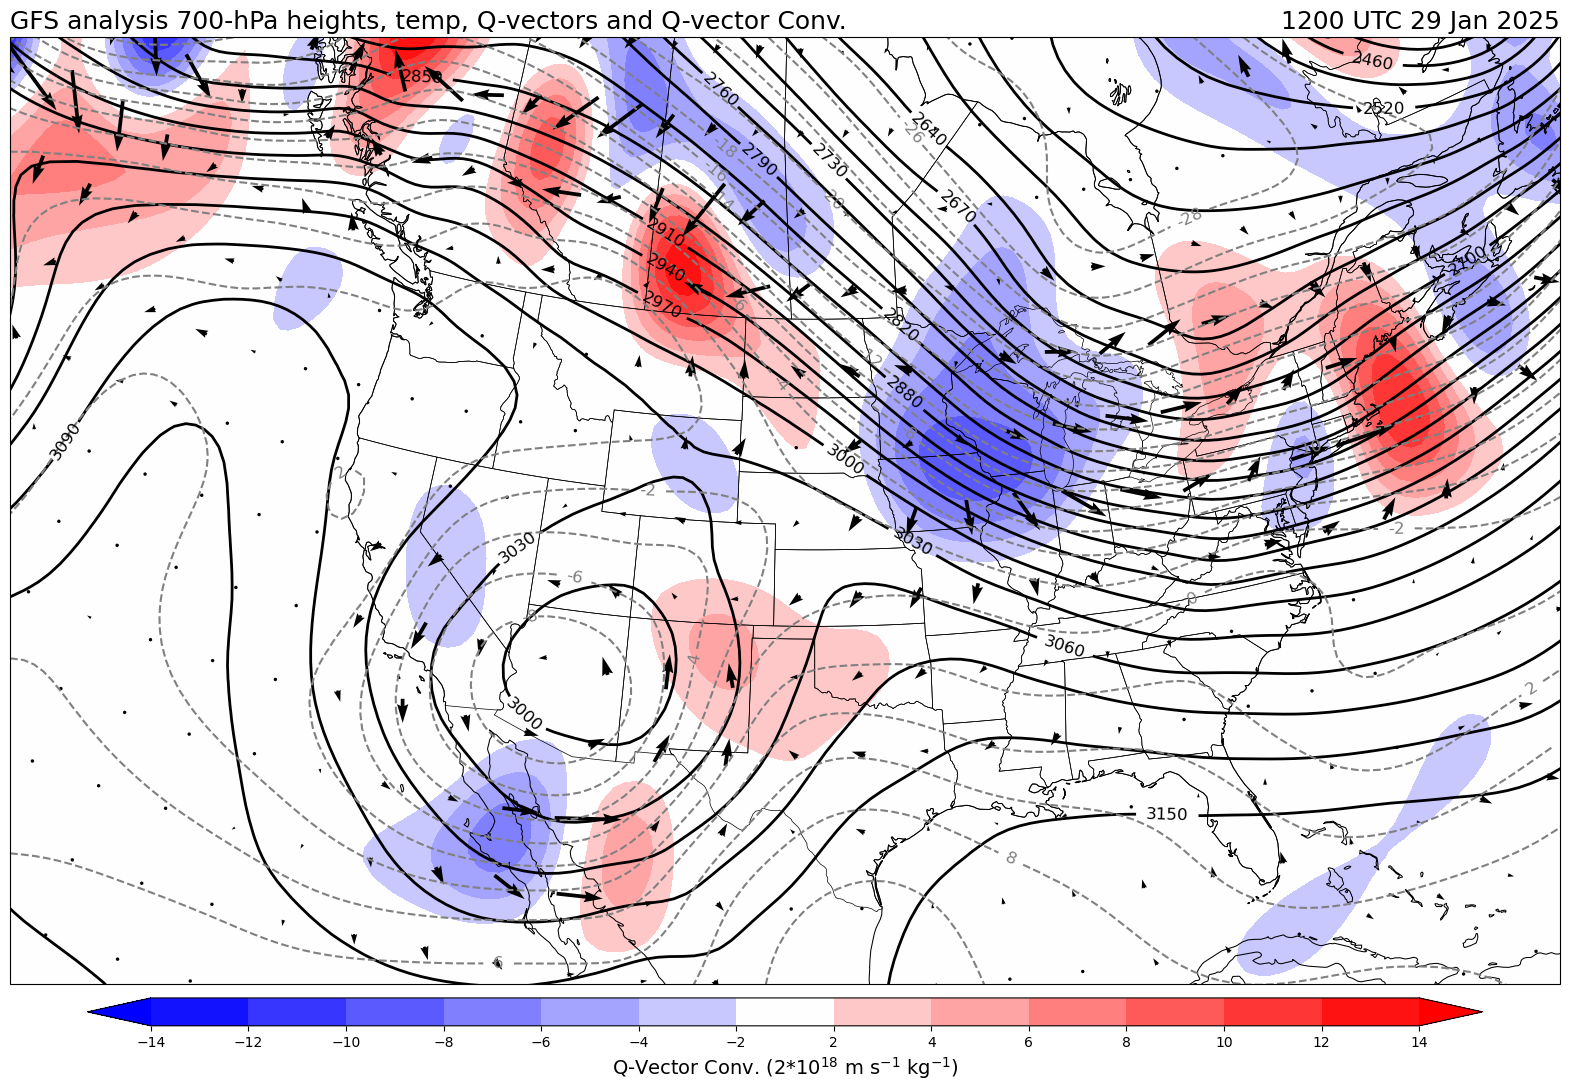

In [16]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# Plot Titles
plt.title(r'GFS analysis 700-hPa heights, temp, Q-vectors and Q-vector Conv.',
          loc='left', fontsize=18)
plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=18)

# Plot Background
#ax.set_extent([217.5, 290., 18., 66.])
ax.set_extent([227.5, 290., 20., 56.])
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Height Contours
clev700 = np.arange(2100, 18001, 30)
cs = ax.contour(data_subset.lon, data_subset.lat, hght_700, clev700, colors='black', linewidths=2,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i', 
                rightside_up=True, use_clabeltext=True)

# Plot temperature Contours
clevtemp700 = np.arange(-30, 20, 2)
cs2 = ax.contour(data_subset.lon, data_subset.lat, tmpk_700.to(units('degC')), clevtemp700, colors='grey',
                 linewidths=1.5, linestyles='dashed', transform=ccrs.PlateCarree())
plt.clabel(cs2, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                 rightside_up=True, use_clabeltext=True)

# Plot 700-hPa Q-Vector Divergence and scale
clevs_qdiv = list(range(-14, -1, 2))+list(range(2, 16, 2))
cf = ax.contourf(data_subset.lon, data_subset.lat, q_div*1e18, clevs_qdiv, extend='both',
                 cmap='bwr', transform=ccrs.PlateCarree())
cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9,
                  ticks=clevs_qdiv)
cb.set_label('Q-Vector Conv. (2*10$^{18}$ m s$^{-1}$ kg$^{-1}$)', fontsize=14)

# Plot 700-hPa Q-vectors, scale to get nice sized arrows
wind_slice = slice(None, None, 6)
ax.quiver(data_subset.lon[wind_slice],data_subset.lat[wind_slice],uqvect[wind_slice,wind_slice].m,vqvect[wind_slice,wind_slice].m,
          pivot='mid', color='black',
          scale=4e-12, scale_units='inches',
          transform=ccrs.PlateCarree())


outfile="700qvect_gfs_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png"
fig.savefig(outfile, dpi=255, bbox_inches='tight', transparent=False, facecolor='white')
#os.system("mv "+outfile+" "+case_date+"/.")
plt.show()

plt.close('all')

Just plot 700-mb heights and temperature (for manual Q-vector estimates)
-------------

In [17]:
hght_700 = mpcalc.smooth_n_point(data_subset['Geopotential_height_isobaric'].metpy.sel(vertical=700*units.hPa), 9)

ugeo_700, vgeo_700 = mpcalc.geostrophic_wind(hght_700)

ugeo_700 = mpcalc.smooth_n_point(ugeo_700,9)
vgeo_700 = mpcalc.smooth_n_point(vgeo_700,9)

## give units to winds & smooth slightly
#ugeo_700 = ndimage.gaussian_filter(ugeo_700, sigma=1, order=0) * units('m/s')
#vgeo_700 = ndimage.gaussian_filter(vgeo_700, sigma=1, order=0) * units('m/s')

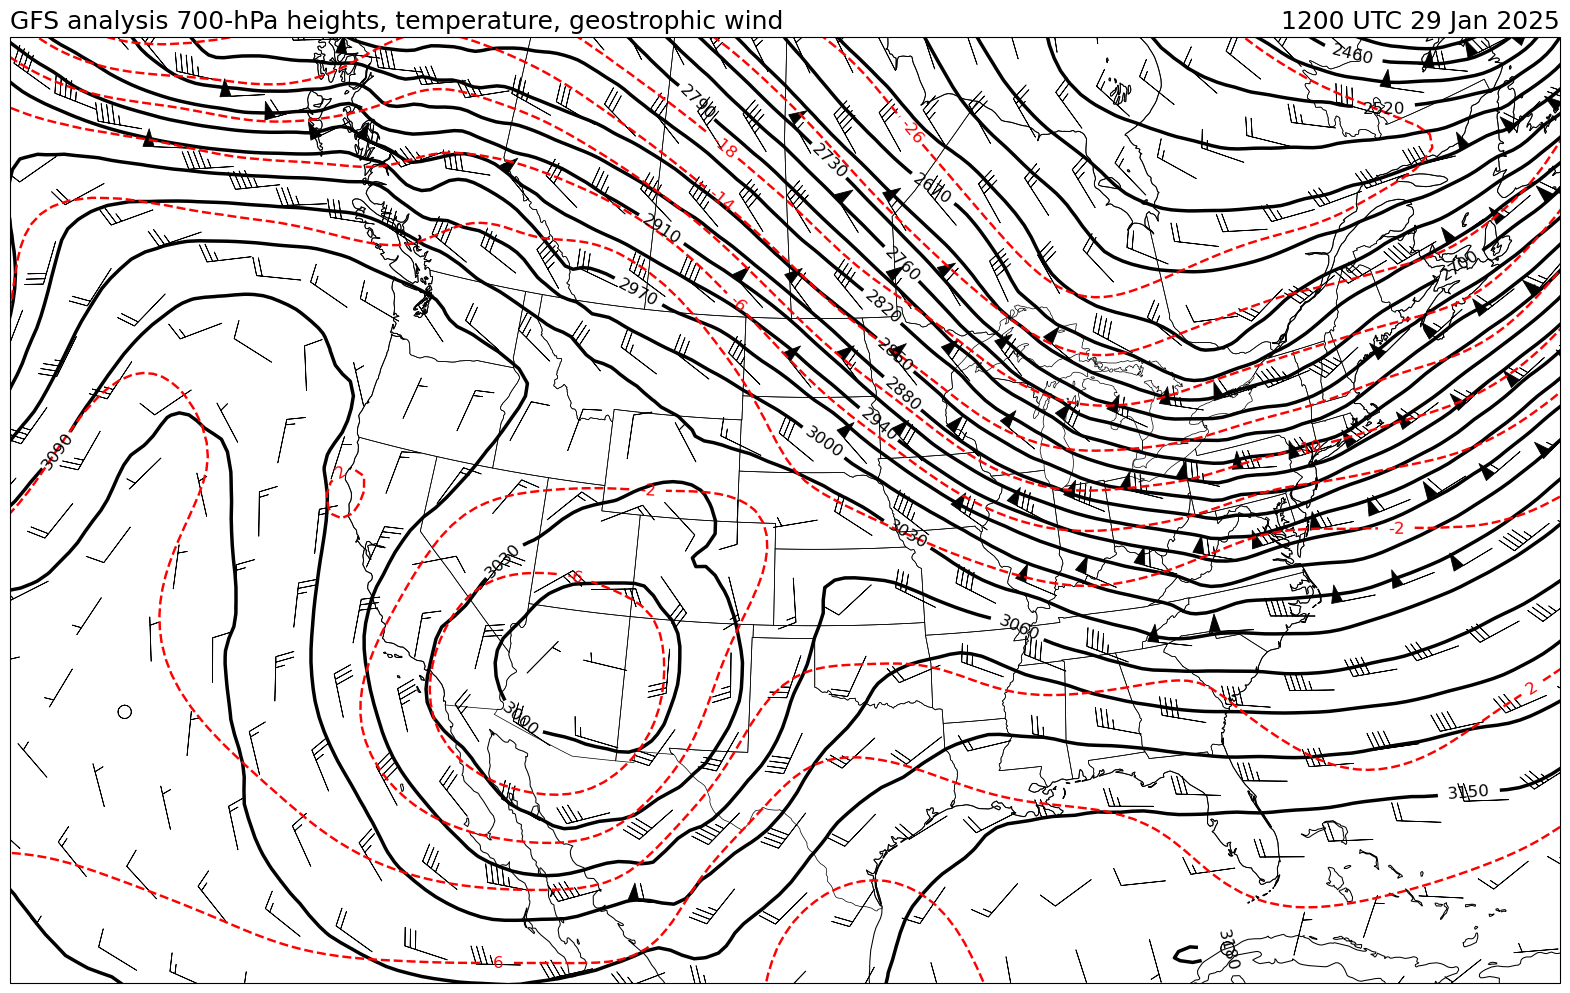

In [18]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# Plot Titles
plt.title(r'GFS analysis 700-hPa heights, temperature, geostrophic wind',
          loc='left', fontsize=18)
plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=18)

# Plot Background
#ax.set_extent([217.5, 290., 18., 66.])
ax.set_extent([227.5, 290., 20., 56.])
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Height Contours
clev700 = np.arange(2100, 18001, 30)
cs = ax.contour(data_subset.lon, data_subset.lat, hght_700, clev700, colors='black', linewidths=2.5,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i', 
                rightside_up=True, use_clabeltext=True)

# Plot temperature Contours
clevtemp700 = np.arange(-30, 33, 4)
cs2 = ax.contour(data_subset.lon, data_subset.lat, tmpk_700.to(units('degC')), clevtemp700, colors='red',
                 linewidths=1.75, linestyles='dashed', transform=ccrs.PlateCarree())
plt.clabel(cs2, fontsize=12, inline=1, inline_spacing=10, fmt='%i',
                 rightside_up=True, use_clabeltext=True)

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
wind_slice = slice(None, None, 6)
ax.barbs(ugeo_700.lon[wind_slice], ugeo_700.lat[wind_slice], ugeo_700.metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         vgeo_700.metpy.convert_units('kt')[wind_slice,wind_slice].values, 
         length=8, linewidth=0.6,pivot='middle', transform=ccrs.PlateCarree())

outfile="700temp_gfs_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png"
fig.savefig(outfile, dpi=255, bbox_inches='tight', transparent=False, facecolor='white')
#os.system("mv "+outfile+" "+case_date+"/.")
plt.show()

plt.close('all')

In [19]:
data_subset

<xarray.Dataset> Size: 19MB
Dimensions:                                  (lat: 101, lon: 211, isobaric: 41,
                                              height_above_ground1: 6)
Coordinates:
  * lat                                      (lat) float32 404B 68.0 ... 18.0
  * lon                                      (lon) float32 844B 205.0 ... 310.0
    reftime                                  datetime64[ns] 8B 2025-01-29T12:...
    time                                     datetime64[ns] 8B 2025-01-29T12:...
  * isobaric                                 (isobaric) float32 164B 1.0 ... ...
    metpy_crs                                object 8B Projection: latitude_l...
  * height_above_ground1                     (height_above_ground1) float32 24B ...
Data variables:
    u-component_of_wind_isobaric             (isobaric, lat, lon) float32 3MB ...
    v-component_of_wind_isobaric             (isobaric, lat, lon) float32 3MB ...
    Temperature_isobaric                     (isobaric, lat, lon) float32 3MB ...
    Geopotential_height_isobaric             (isobaric, lat, lon) float32 3MB ...
    Relative_humidity_isobaric               (isobaric, lat, lon) float32 3MB ...
    Geopotential_height_surface              (lat, lon) float32 85kB ...
    Pressure_reduced_to_MSL_msl              (lat, lon) float32 85kB ...
    u-component_of_wind_height_above_ground  (height_above_ground1, lat, lon) float32 511kB ...
    v-component_of_wind_height_above_ground  (height_above_ground1, lat, lon) float32 511kB ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

DT theta
---------------

Calculate PV

In [20]:
data_subset['Potential_temperature'] = mpcalc.potential_temperature(
    data_subset['isobaric'],
    data_subset['Temperature_isobaric']
)

data_subset['Potential_vorticity'] = mpcalc.potential_vorticity_baroclinic(
    data_subset['Potential_temperature'], data_subset['isobaric'], 
    data_subset['u-component_of_wind_isobaric'], data_subset['v-component_of_wind_isobaric'])

# Compute ground elevation in pressure from standard atmsophere and the elevation
# of each station
data_subset['elevation'] = mpcalc.height_to_pressure_std(data_subset['Geopotential_height_surface']*units.meters)
                                                         #* units('meters'))

Also a separate subset for data on the DT

In [21]:
dt_subset = data.metpy.parse_cf([
    'Temperature_potential_vorticity_surface',
    'Pressure_potential_vorticity_surface',
    'u-component_of_wind_potential_vorticity_surface',
    'v-component_of_wind_potential_vorticity_surface',
]).sel(time=vtime).squeeze()

## subset to North America
dt_subset = dt_subset.sel(lon=slice(205,310.), lat=slice(68.,18.), potential_vorticity_surface=2.e-6)
  

Calculate theta and smooth

In [22]:
dt_subset['Potential_temperature'] = mpcalc.potential_temperature(
    dt_subset['Pressure_potential_vorticity_surface'],
    dt_subset['Temperature_potential_vorticity_surface']
)

dt_theta = mpcalc.smooth_n_point(dt_subset['Potential_temperature'], 9)
#dt_theta = ndimage.gaussian_filter(dt_subset['Potential_temperature'], sigma=1, order=0) * units('kelvin')

Also get and plot 850-hPa relative vorticity

In [23]:
hght_850 = mpcalc.smooth_n_point(data_subset['Geopotential_height_isobaric'].metpy.sel(vertical=850*units.hPa), 5)
uwnd_850 = data_subset['u-component_of_wind_isobaric'].metpy.sel(vertical=850*units.hPa)
vwnd_850 = data_subset['v-component_of_wind_isobaric'].metpy.sel(vertical=850*units.hPa)

avor_850 = mpcalc.smooth_n_point(mpcalc.vorticity(uwnd_850, vwnd_850),9)

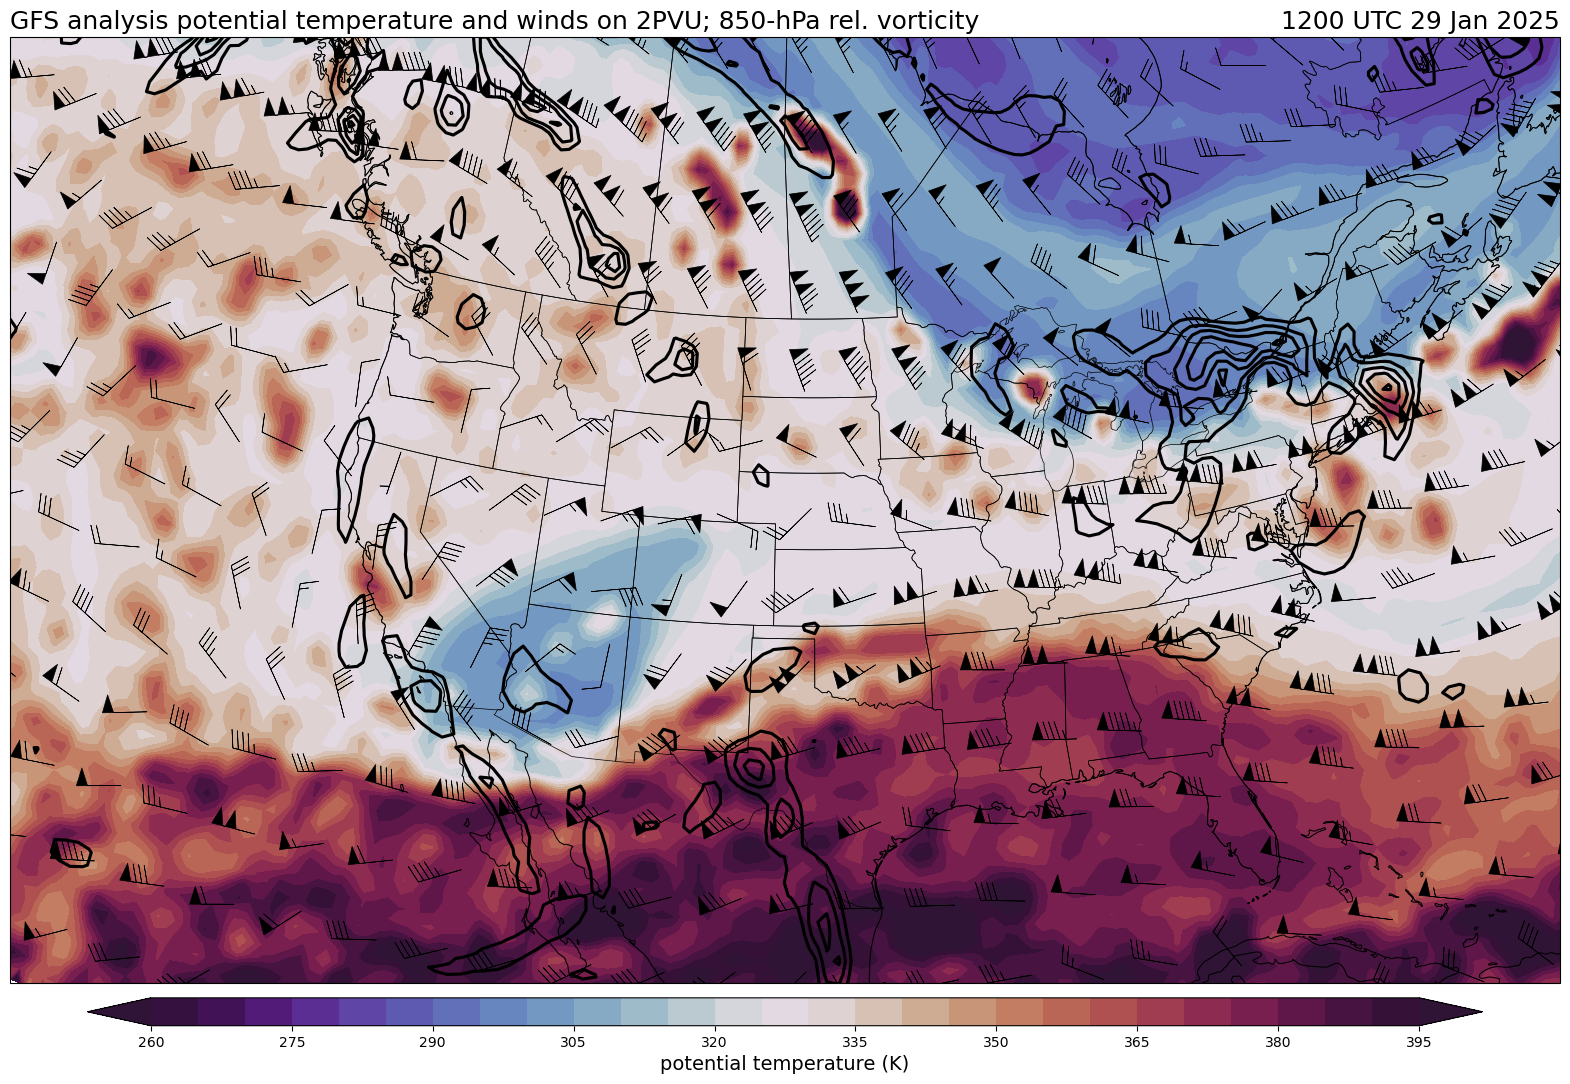

In [24]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=plotcrs)

# Plot Titles
plt.title(r'GFS analysis potential temperature and winds on 2PVU; 850-hPa rel. vorticity',
          loc='left', fontsize=18)
plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=18)

# Plot Background
#ax.set_extent([217.5, 290., 18., 66.])
ax.set_extent([227.5, 290., 20., 56.])
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Colorfill DT theta
clevs_dt = np.arange(260,400,5)
cf = ax.contourf(dt_subset.lon, dt_subset.lat, dt_theta, clevs_dt, cmap=plt.cm.twilight_shifted,
                 extend='both',
                 transform=ccrs.PlateCarree())
cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9)
cb.set_label('potential temperature (K)', fontsize=14)

# Plot vort contours
clev850 = np.arange(4,40,4)
cs = ax.contour(data_subset.lon, data_subset.lat, avor_850*1e5, clev850, 
                colors='black', linewidths=2.25,
                linestyles='solid', transform=ccrs.PlateCarree())
#plt.clabel(cs, fontsize=12, inline=1, inline_spacing=10, fmt='%i', 
#                rightside_up=True, use_clabeltext=True)

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
wind_slice = slice(None, None, 6)
ax.barbs(dt_subset.lon[wind_slice], dt_subset.lat[wind_slice], 
         dt_subset['u-component_of_wind_potential_vorticity_surface'][wind_slice,wind_slice].metpy.convert_units('kt').values,
         dt_subset['v-component_of_wind_potential_vorticity_surface'][wind_slice,wind_slice].metpy.convert_units('kt').values,
         length=8, linewidth=0.5,pivot='middle', transform=ccrs.PlateCarree())

outfile="dt_theta_gfs_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png"
fig.savefig(outfile, dpi=255, bbox_inches='tight', transparent=False, facecolor='white')
#os.system("mv "+outfile+" "+case_date+"/.")
plt.show()

plt.close('all')